# import modules

In [466]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
# light blue and orange
correct_color = "tab:blue"
incorrect_color = "tab:orange"
SEED = 314

# define functions

In [467]:
def calc_accuracy(df):
    return (df['true_label'] == df['predict_label']).sum() / len(df)

def calc_score(df):
    acc = calc_accuracy(df)
    rcl = recall_score(df['true_label'], df['predict_label'], average='macro')
    prc = precision_score(df['true_label'], df['predict_label'], average='macro')
    f1 = f1_score(df['true_label'], df['predict_label'], average='macro')
    size = len(df)
    return {"acc": acc, "rcl": rcl, "prc": prc, "f1": f1, "size": size}

def preprocess_df(raw_df:pd.DataFrame, true_label:pd.DataFrame)->pd.DataFrame:
    df = raw_df.copy()
    LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
    min_max_func = lambda x: (x - x.min()) / (x.max() - x.min()) # min-max normalization
    convert_probability_func = lambda x: x / x.sum() # convert to binary
    processed_df = df.apply(min_max_func, axis=1).apply(convert_probability_func, axis=1)
    processed_df.columns = LABELS
    processed_df["predict_probability"] = processed_df.max(axis=1)
    processed_df["predict_label"] = processed_df.idxmax(axis=1)
    processed_df['true_label'] = true_label.map(lambda x: LABELS[x])
    return processed_df

def show_count(processed_df, title):
    df = processed_df.copy()
    acc = calc_accuracy(df)
    df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
    df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
    df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color])
    plt.title(f'{title}\nPredict Probability Count\nACC: {acc:.4f}')
    plt.xlim(0,1)
    plt.ylim(0,400)
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.legend(['Incorrect', 'Correct'])
    # plt.savefig(f'assets/{title}-count.png')
    plt.show()

def show_count_stacked(processed_df, title, split_size=0.01):
    df = processed_df.copy()
    acc = calc_accuracy(df)
    df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
    df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
    df = df.loc[:,['incorrect', 'correct',]]
    correct_list = list()
    incorrect_list = list()
    split_num = int(1/split_size)
    for i in range(split_num,0,-1):
        i *= split_size
        correct_list.append((df.correct>i).sum())
        incorrect_list.append((df.incorrect>i).sum())
    correct_list.reverse()
    incorrect_list.reverse()
    plt.bar(np.arange(split_num)*split_size, incorrect_list, width=split_size, color=incorrect_color)
    plt.bar(np.arange(split_num)*split_size, correct_list, width=split_size, color=correct_color, bottom=incorrect_list)
    plt.title(f'{title}\nPredict Probability Stacked Count\nACC: {acc:.4f}')
    plt.xlim(0,1)
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.legend(['Incorrect', 'Correct'])
    # plt.savefig(f'assets/{title}-count-stacked.png')
    plt.show()

def show_dist(processed_df, title):
    df = processed_df.copy()
    acc = calc_accuracy(df)
    df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
    df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
    df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color])
    plt.title(f'{title}\nPredict Probability Count\nACC: {acc:.4f}')
    plt.xlim(0,1)
    plt.ylim(0,400)
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.legend(['Incorrect', 'Correct'])
    split_size = 0.1
    df = processed_df.copy()
    acc = calc_accuracy(df)
    df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
    df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
    df = df.loc[:,['incorrect', 'correct',]]
    correct_list = list()
    incorrect_list = list()
    split_num = int(1/split_size)
    for i in range(split_num,0,-1):
        i *= split_size
        correct_list.append((df.correct>i).sum())
        incorrect_list.append((df.incorrect>i).sum())
    correct_list.reverse()
    incorrect_list.reverse()
    plt.bar(np.arange(split_num)*split_size, incorrect_list, width=split_size, color=incorrect_color)
    plt.bar(np.arange(split_num)*split_size, correct_list, width=split_size, color=correct_color, bottom=incorrect_list)
    plt.title(f'{title}\nPredict Probability Stacked Count\nACC: {acc:.4f}')
    plt.ylabel('Count')
    plt.legend(['Incorrect', 'Correct'])
    # plt.savefig(f'assets/{title}-count-stacked.png')
    plt.show()

def show_confusion_matrix(df, title):
    LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
    cm = confusion_matrix(df['true_label'], df['predict_label'], labels=LABELS)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels=LABELS, yticklabels=LABELS)
    plt.title(f'{title}\nConfusion Matrix\nACC: {calc_accuracy(df):.4f}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    # plt.savefig(f'assets/{title}-confusion-matrix.png')
    plt.show()

def calc_thredshold_df(df):
    delta = 0.01
    thresholds = [i*delta for i in range(int(1//delta+1))]
    acc_list = list()
    count_list = list()
    for threshold in thresholds:
        acc_list.append(calc_accuracy(df.loc[df.predict_probability>threshold]))
        count_list.append(len(df.loc[df.predict_probability>threshold]))
    threshold_df = pd.DataFrame({'threshold': thresholds, 'accuracy': acc_list, 'count': count_list})
    return threshold_df.set_index('threshold')

# load data

In [468]:
convbbt_layer3_raw_df = pd.read_csv('../convbbt-layer:3/predict.csv', index_col=0).drop(columns=["true"])
convbbt_layer5_raw_df = pd.read_csv('../convbbt/predict.csv', index_col=0).drop(columns=["true"])
convbbt_layer7_raw_df = pd.read_csv('../convbbt-layer:7/predict.csv', index_col=0).drop(columns=["true"])
true_label = pd.read_csv('../convbbt/predict.csv', index_col=0)["true"]

# check data

## raw data head

In [469]:
convbbt_layer3_raw_df.head()

,0,1,2,3,4,5
0,4.794195,-8.249228,-9.894946,-5.896336,0.786684,5.269970
1,-0.641768,-9.602808,14.231035,0.573691,0.052295,1.060287
2,2.612563,-11.385828,-12.903688,-0.402864,9.754886,0.731949
3,1.384545,17.906736,-4.959831,-6.789407,-3.877294,-2.255584
4,-4.220795,-6.356165,-3.674784,14.070560,-2.290916,3.999891


In [470]:
convbbt_layer5_raw_df.head()

,0,1,2,3,4,5
0,2.667278,-6.223639,-10.455910,-7.705863,3.942457,5.992100
1,-3.501386,-5.147262,15.075128,7.256400,-0.475929,-2.861587
2,3.822823,-9.720933,-9.241361,-5.683146,6.891798,3.425873
3,3.279096,11.735168,-4.228587,-1.351361,-4.169562,-4.644408
4,-2.105618,-2.101908,0.199927,13.780579,-3.819936,-1.524870


In [471]:
convbbt_layer7_raw_df.head()

,0,1,2,3,4,5
0,5.036437,-4.502230,-6.603404,-5.567816,-1.089012,7.162587
1,-3.746440,-7.409843,14.647223,1.599128,-0.146993,0.334431
2,1.839661,-10.998505,-6.005250,-5.750884,8.651728,2.211259
3,-1.004645,13.123766,-5.008782,-5.039395,-2.758281,-1.509961
4,-3.875755,-1.584597,4.366080,13.186352,-8.073782,4.969984


In [472]:
convbbt_layer3_df = preprocess_df(convbbt_layer3_raw_df, true_label)
convbbt_layer5_df = preprocess_df(convbbt_layer5_raw_df, true_label)
convbbt_layer7_df = preprocess_df(convbbt_layer7_raw_df, true_label)

## processed data head

In [473]:
convbbt_layer3_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label
0,0.318084,0.035637,0.000000,0.086587,0.231304,0.328387,0.328387,Walking,Walking
1,0.141588,0.000000,0.376584,0.160793,0.152554,0.168481,0.376584,Sitting,Sitting
2,0.235705,0.023058,0.000000,0.189898,0.344203,0.207137,0.344203,Upstairs,Upstairs
3,0.193946,0.585972,0.043411,0.000000,0.069096,0.107575,0.585972,Jogging,Jogging
4,0.053835,0.000000,0.067601,0.514984,0.102490,0.261089,0.514984,Standing,Standing


In [474]:
convbbt_layer5_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label
0,0.257560,0.083064,0.000000,0.053973,0.282588,0.322815,0.322815,Walking,Walking
1,0.039920,0.000000,0.490490,0.300848,0.113302,0.055439,0.490490,Sitting,Sitting
2,0.283220,0.000000,0.010029,0.084436,0.347397,0.274919,0.347397,Upstairs,Upstairs
3,0.278147,0.574988,0.014597,0.115599,0.016669,0.000000,0.574988,Jogging,Jogging
4,0.062686,0.062821,0.146990,0.643581,0.000000,0.083921,0.643581,Standing,Standing


# Eval-Test split(with StratifiedKFold)

In [475]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
test_index, eval_index = skf.split(convbbt_layer3_df, true_label).__next__()

In [476]:
eval_index.__len__()

824

In [477]:
test_index.__len__()

7413

In [478]:
convbbt_layer3_eval_df, convbbt_layer3_test_df = convbbt_layer3_df.iloc[eval_index], convbbt_layer3_df.iloc[test_index]
convbbt_layer5_eval_df, convbbt_layer5_test_df = convbbt_layer5_df.iloc[eval_index], convbbt_layer5_df.iloc[test_index]
convbbt_layer7_eval_df, convbbt_layer7_test_df = convbbt_layer7_df.iloc[eval_index], convbbt_layer7_df.iloc[test_index]
true_eval_label, true_test_label = true_label.iloc[eval_index], true_label.iloc[test_index]
del convbbt_layer3_df, convbbt_layer5_df, convbbt_layer7_df

In [479]:
len(convbbt_layer3_eval_df), len(convbbt_layer3_test_df)

(824, 7413)

## count

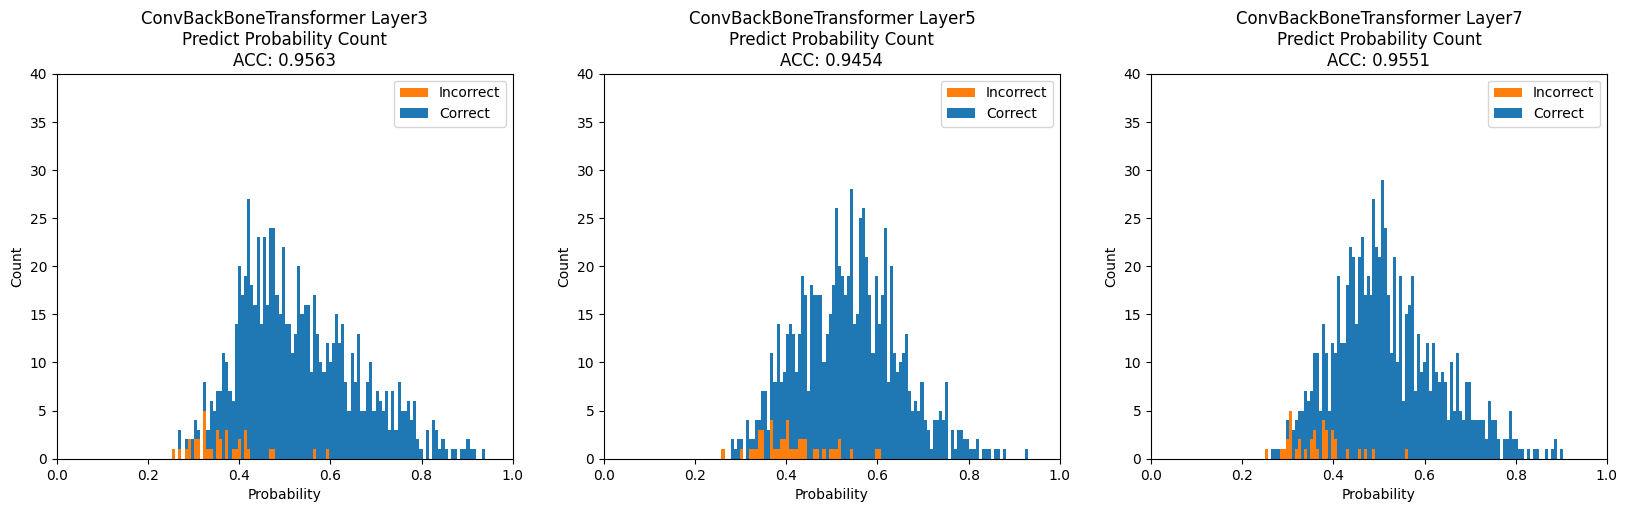

In [480]:
# 3枚描画空間を確保
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
x_limit = (0, 1)
y_limit = (0, 40)
x_label = 'Probability'
y_label = 'Count'
legend = ['Incorrect', 'Correct']

# 1枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer3'
df = convbbt_layer3_eval_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[0])
axes[0].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[0].legend(legend)
# 2枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer5'
df = convbbt_layer5_eval_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[1])
axes[1].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[1].legend(legend)
# 3枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer7'
df = convbbt_layer7_eval_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[2])
axes[2].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[2].legend(legend)

plt.show()

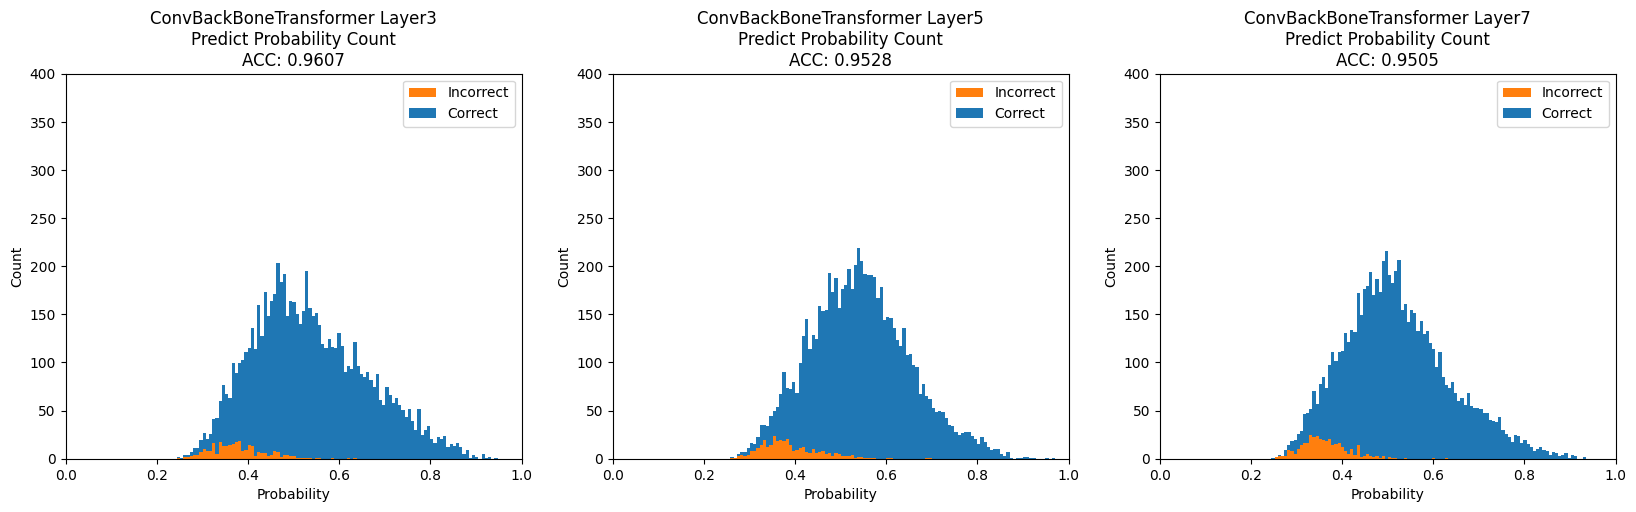

In [481]:
# 3枚描画空間を確保
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
x_limit = (0, 1)
y_limit = (0, 400)
x_label = 'Probability'
y_label = 'Count'
legend = ['Incorrect', 'Correct']

# 1枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer3'
df = convbbt_layer3_test_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[0])
axes[0].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[0].legend(legend)
# 2枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer5'
df = convbbt_layer5_test_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[1])
axes[1].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[1].legend(legend)
# 3枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer7'
df = convbbt_layer7_test_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[2])
axes[2].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[2].legend(legend)

plt.show()

## Stacked Count

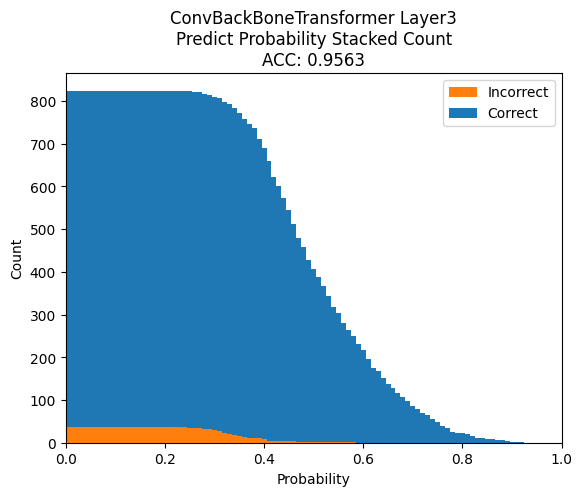

In [482]:
show_count_stacked(convbbt_layer3_eval_df, 'ConvBackBoneTransformer Layer3')

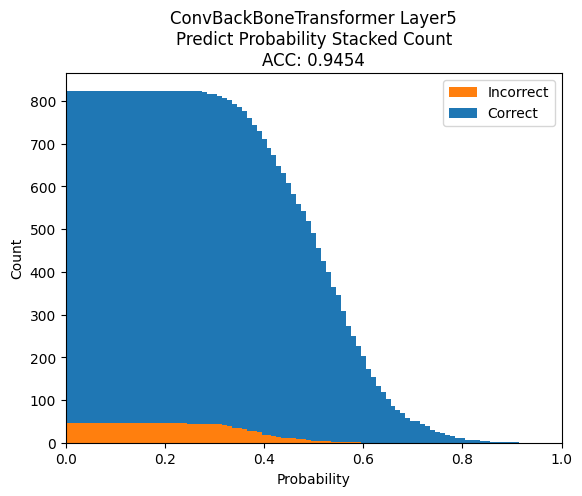

In [483]:
show_count_stacked(convbbt_layer5_eval_df, 'ConvBackBoneTransformer Layer5')

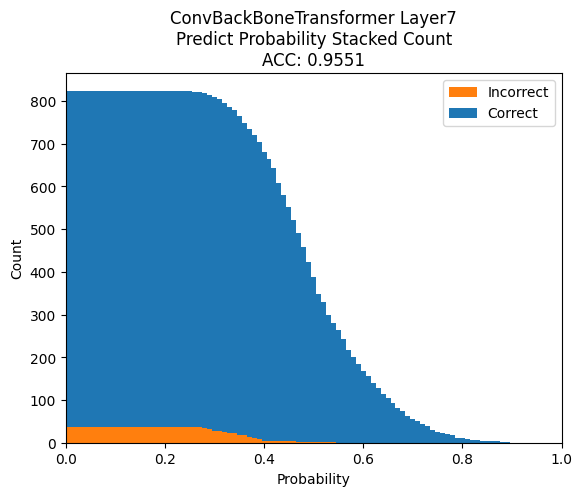

In [484]:
show_count_stacked(convbbt_layer7_eval_df, 'ConvBackBoneTransformer Layer7')

# Ensamble Model

## 2. Vote Ensamble

In [485]:
ensamble2_name = 'Vote-Ensamble'

In [486]:
LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
modelnames = ["ConvBackBoneTransformer Layer3", "ConvBackBoneTransformer Layer5", "ConvBackBoneTransformer Layer7"]
ensamble2_label_df = pd.concat([convbbt_layer3_test_df.loc[:, "predict_label"].copy(), convbbt_layer5_test_df.loc[:, "predict_label"].copy(), convbbt_layer7_test_df.loc[:, "predict_label"].copy()], axis=1)
ensamble2_probability_df= pd.concat([convbbt_layer3_test_df.loc[:, "predict_probability"].copy(), convbbt_layer5_test_df.loc[:, "predict_probability"].copy(), convbbt_layer7_test_df.loc[:, "predict_probability"].copy()], axis=1)
ensamble2_label_df.columns = modelnames
ensamble2_probability_df.columns = modelnames
ensamble2_df = pd.DataFrame({
                        "predict_label": ensamble2_label_df.apply(lambda x: x.value_counts().idxmax(), axis=1),
                        "predict_probability": ensamble2_probability_df.max(axis=1),
                        "true_label": true_test_label.map(lambda x: LABELS[x]), "predict_probability": ensamble2_probability_df.max(axis=1),
                        })

In [487]:
ensamble2_df.head()

,predict_label,predict_probability,true_label
0,Walking,0.404205,Walking
1,Sitting,0.490490,Sitting
2,Upstairs,0.351279,Upstairs
3,Jogging,0.647780,Jogging
4,Standing,0.643581,Standing


In [488]:
value_counts = ensamble2_label_df.apply(lambda x: x.value_counts(), axis=1)

vote_3_index = value_counts.loc[(value_counts == 3).apply(lambda x: any(x), axis=1),:].index
vote_2_index = value_counts.loc[(value_counts == 2).apply(lambda x: any(x), axis=1),:].index
vote_1_index = list(set(value_counts.loc[(value_counts == 1).apply(lambda x: any(x), axis=1),:].index) - set(vote_2_index))

vote_3 = pd.DataFrame({
                "predict_label": ensamble2_label_df.loc[vote_3_index,:].apply(lambda x: x.value_counts().idxmax(), axis=1), 
                "true_label": true_test_label.loc[vote_3_index].map(lambda x: LABELS[x])
                })
vote_2 = pd.DataFrame({
                "predict_label": ensamble2_label_df.loc[vote_2_index,:].apply(lambda x: x.value_counts().idxmax(), axis=1), 
                "true_label": true_test_label.loc[vote_2_index].map(lambda x: LABELS[x])
                })

vote_1 = pd.DataFrame({
                "predict_label": ensamble2_label_df.loc[vote_1_index,:].apply(lambda x: x.value_counts().idxmax(), axis=1), 
                "true_label": true_test_label.loc[vote_1_index].map(lambda x: LABELS[x])
                }) if len(vote_1_index)!=0 else pd.DataFrame(columns=["predict_label", "true_label"])

In [489]:
print('All num: ', len(ensamble2_label_df))
print(f'Vote 3 num: {len(vote_3)}')
print(f'Vote 2 num: {len(vote_2)}')
print(f'Vote 1 num: {len(vote_1)}')

All num:  7413
Vote 3 num: 6923
Vote 2 num: 461
Vote 1 num: 29


In [490]:
score_df = pd.DataFrame(columns=["acc", "rcl", "prc", "f1", "size"])
score_df.loc["Vote 3"] = calc_score(vote_3)
score_df.loc["Vote 2"] = calc_score(vote_2)
score_df.loc["Vote 1"] = calc_score(vote_1)
score_df.loc["Vote All"] = calc_score(ensamble2_df)
vote_a_score = score_df.loc["Vote 3",:].copy()
score_df

/home/nakagawaren/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,acc,rcl,prc,f1,size
Vote 3,0.985700,0.974219,0.979816,0.976981,6923
Vote 2,0.665944,0.593419,0.542256,0.563147,461
Vote 1,0.482759,0.351852,0.336616,0.311260,29
Vote All,0.963847,0.947844,0.955720,0.951505,7413


## 4. Handle Ensamble

In [491]:
ensamble4_name = 'Handle-Ensamble'

In [492]:
calc_thredshold_df(convbbt_layer3_eval_df).dropna()

/tmp/ipykernel_9768/2184103812.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,accuracy,count
threshold,,
0.00,0.956311,824
0.01,0.956311,824
0.02,0.956311,824
0.03,0.956311,824
0.04,0.956311,824
...,...,...
0.89,1.000000,6
0.90,1.000000,5
0.91,1.000000,2


In [493]:
calc_thredshold_df(convbbt_layer5_eval_df).dropna()

/tmp/ipykernel_9768/2184103812.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,accuracy,count
threshold,,
0.00,0.945388,824
0.01,0.945388,824
0.02,0.945388,824
0.03,0.945388,824
0.04,0.945388,824
...,...,...
0.88,1.000000,1
0.89,1.000000,1
0.90,1.000000,1


In [494]:
calc_thredshold_df(convbbt_layer7_eval_df).dropna()

/tmp/ipykernel_9768/2184103812.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,accuracy,count
threshold,,
0.00,0.955097,824
0.01,0.955097,824
0.02,0.955097,824
0.03,0.955097,824
0.04,0.955097,824
...,...,...
0.86,1.000000,5
0.87,1.000000,4
0.88,1.000000,4


In [495]:
convbbt_layer3_995threshold = calc_thredshold_df(convbbt_layer3_eval_df).accuracy.map(lambda x: x if x>0.995 else np.nan).idxmin()
convbbt_layer5_995threshold = calc_thredshold_df(convbbt_layer5_eval_df).accuracy.map(lambda x: x if x>0.995 else np.nan).idxmin()
convbbt_layer7_995threshold = calc_thredshold_df(convbbt_layer7_eval_df).accuracy.map(lambda x: x if x>0.995 else np.nan).idxmin()

convbbt_layer3_98threshold = calc_thredshold_df(convbbt_layer3_eval_df).accuracy.map(lambda x: x if x>0.98 else np.nan).idxmin()
convbbt_layer5_98threshold = calc_thredshold_df(convbbt_layer5_eval_df).accuracy.map(lambda x: x if x>0.98 else np.nan).idxmin()
convbbt_layer7_98threshold = calc_thredshold_df(convbbt_layer7_eval_df).accuracy.map(lambda x: x if x>0.98 else np.nan).idxmin()

convbbt_layer3_97threshold = calc_thredshold_df(convbbt_layer3_eval_df).accuracy.map(lambda x: x if x>0.97 else np.nan).idxmin()
convbbt_layer5_97threshold = calc_thredshold_df(convbbt_layer5_eval_df).accuracy.map(lambda x: x if x>0.97 else np.nan).idxmin()
convbbt_layer7_97threshold = calc_thredshold_df(convbbt_layer7_eval_df).accuracy.map(lambda x: x if x>0.97 else np.nan).idxmin()

convbbt_layer3_96threshold = calc_thredshold_df(convbbt_layer3_eval_df).accuracy.map(lambda x: x if x>0.96 else np.nan).idxmin()
convbbt_layer5_96threshold = calc_thredshold_df(convbbt_layer5_eval_df).accuracy.map(lambda x: x if x>0.96 else np.nan).idxmin()
convbbt_layer7_96threshold = calc_thredshold_df(convbbt_layer7_eval_df).accuracy.map(lambda x: x if x>0.96 else np.nan).idxmin()
convbbt_layer3_99threshold = calc_thredshold_df(convbbt_layer3_eval_df).accuracy.map(lambda x: x if x>0.99 else np.nan).idxmin()
convbbt_layer5_99threshold = calc_thredshold_df(convbbt_layer5_eval_df).accuracy.map(lambda x: x if x>0.99 else np.nan).idxmin()
convbbt_layer7_99threshold = calc_thredshold_df(convbbt_layer7_eval_df).accuracy.map(lambda x: x if x>0.99 else np.nan).idxmin()

convbbt_layer3_98threshold = calc_thredshold_df(convbbt_layer3_eval_df).accuracy.map(lambda x: x if x>0.98 else np.nan).idxmin()
convbbt_layer5_98threshold = calc_thredshold_df(convbbt_layer5_eval_df).accuracy.map(lambda x: x if x>0.98 else np.nan).idxmin()
convbbt_layer7_98threshold = calc_thredshold_df(convbbt_layer7_eval_df).accuracy.map(lambda x: x if x>0.98 else np.nan).idxmin()

convbbt_layer3_97threshold = calc_thredshold_df(convbbt_layer3_eval_df).accuracy.map(lambda x: x if x>0.97 else np.nan).idxmin()
convbbt_layer5_97threshold = calc_thredshold_df(convbbt_layer5_eval_df).accuracy.map(lambda x: x if x>0.97 else np.nan).idxmin()
convbbt_layer7_97threshold = calc_thredshold_df(convbbt_layer7_eval_df).accuracy.map(lambda x: x if x>0.97 else np.nan).idxmin()

convbbt_layer3_96threshold = calc_thredshold_df(convbbt_layer3_eval_df).accuracy.map(lambda x: x if x>0.96 else np.nan).idxmin()
convbbt_layer5_96threshold = calc_thredshold_df(convbbt_layer5_eval_df).accuracy.map(lambda x: x if x>0.96 else np.nan).idxmin()
convbbt_layer7_96threshold = calc_thredshold_df(convbbt_layer7_eval_df).accuracy.map(lambda x: x if x>0.96 else np.nan).idxmin()

/tmp/ipykernel_9768/2184103812.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_9768/2184103812.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_9768/2184103812.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_9768/2184103812.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_9768/2184103812.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_9768/2184103812.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_9768/21

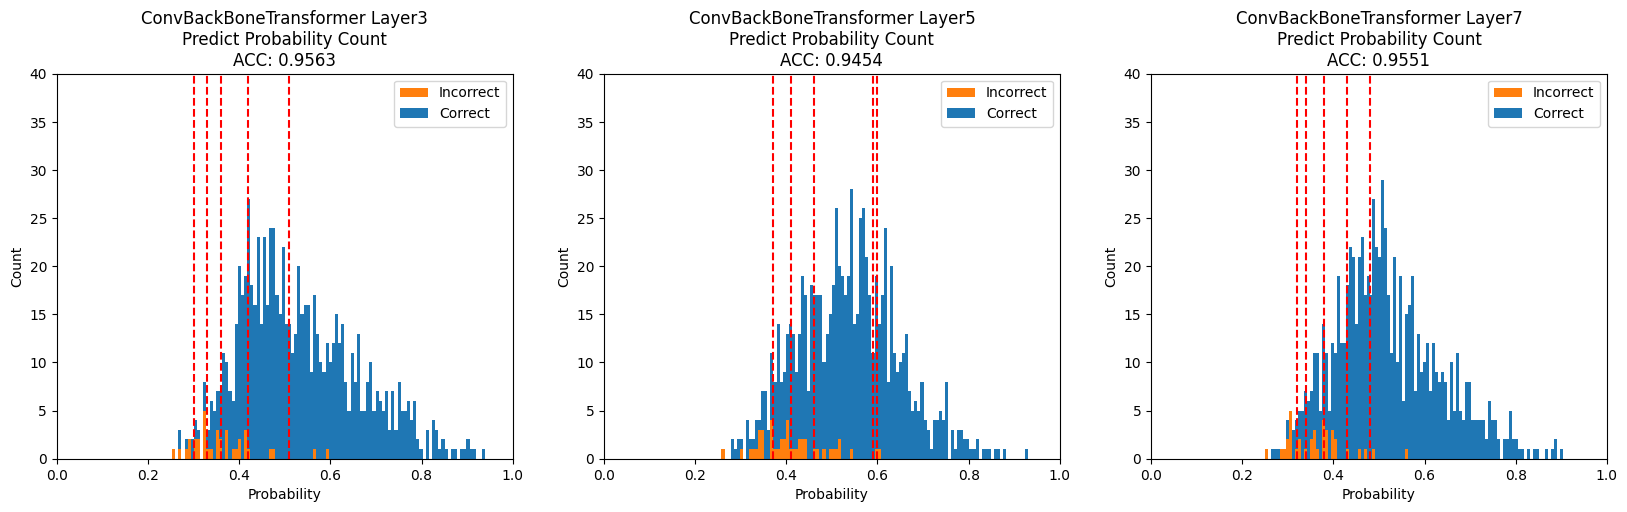

In [496]:
# 3枚描画空間を確保
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
x_limit = (0, 1)
y_limit = (0, 40)
x_label = 'Probability'
y_label = 'Count'
legend = ['Incorrect', 'Correct']

# 1枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer3'
df = convbbt_layer3_eval_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[0])
# 閾値の描画
axes[0].axvline(convbbt_layer3_995threshold, color='r', linestyle='--')
axes[0].axvline(convbbt_layer3_99threshold, color='r', linestyle='--')
axes[0].axvline(convbbt_layer3_98threshold, color='r', linestyle='--')
axes[0].axvline(convbbt_layer3_97threshold, color='r', linestyle='--')
axes[0].axvline(convbbt_layer3_96threshold, color='r', linestyle='--')
axes[0].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[0].legend(legend)
# 2枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer5'
df = convbbt_layer5_eval_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[1])
# 閾値の描画
axes[1].axvline(convbbt_layer5_995threshold, color='r', linestyle='--')
axes[1].axvline(convbbt_layer5_99threshold, color='r', linestyle='--')
axes[1].axvline(convbbt_layer5_98threshold, color='r', linestyle='--')
axes[1].axvline(convbbt_layer5_97threshold, color='r', linestyle='--')
axes[1].axvline(convbbt_layer5_96threshold, color='r', linestyle='--')
axes[1].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[1].legend(legend)
# 3枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer7'
df = convbbt_layer7_eval_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[2])
# 閾値の描画
axes[2].axvline(convbbt_layer7_995threshold, color='r', linestyle='--')
axes[2].axvline(convbbt_layer7_99threshold, color='r', linestyle='--')
axes[2].axvline(convbbt_layer7_98threshold, color='r', linestyle='--')
axes[2].axvline(convbbt_layer7_97threshold, color='r', linestyle='--')
axes[2].axvline(convbbt_layer7_96threshold, color='r', linestyle='--')
axes[2].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[2].legend(legend)

plt.show()

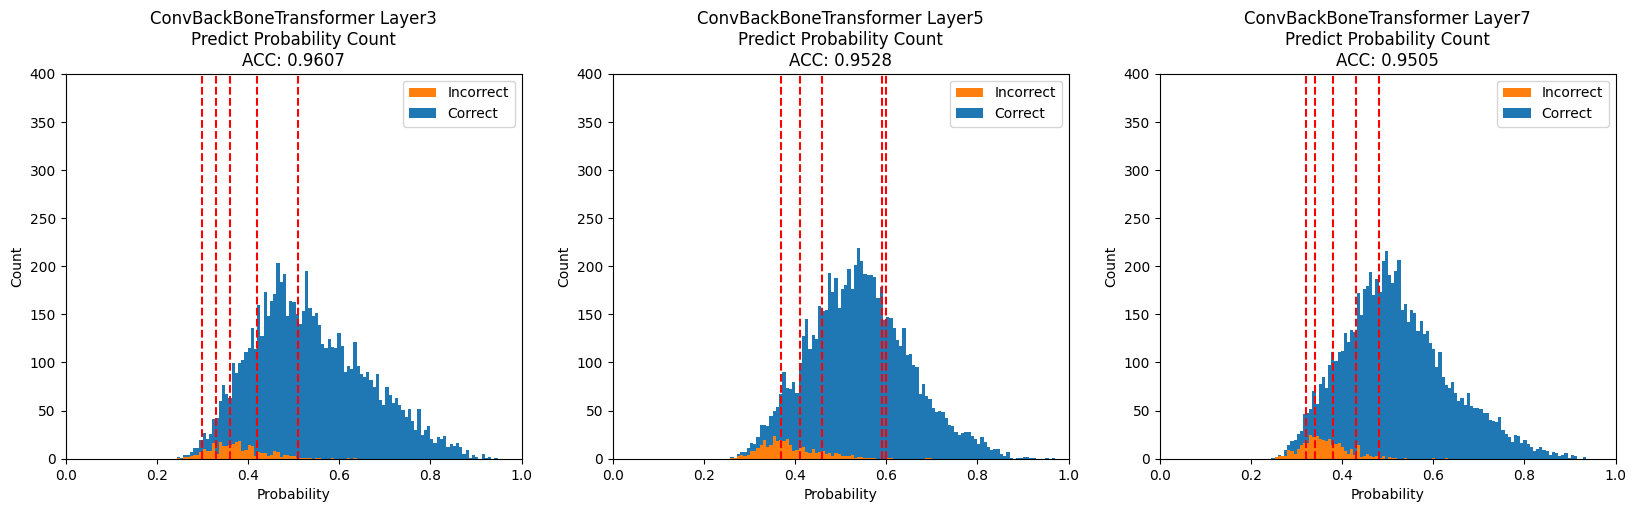

In [497]:
# 3枚描画空間を確保
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
x_limit = (0, 1)
y_limit = (0, 400)
x_label = 'Probability'
y_label = 'Count'
legend = ['Incorrect', 'Correct']

# 1枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer3'
df = convbbt_layer3_test_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[0])
# 閾値の描画（わかりやすく）
axes[0].axvline(convbbt_layer3_995threshold, color='r', linestyle='--')
axes[0].axvline(convbbt_layer3_99threshold, color='r', linestyle='--')
axes[0].axvline(convbbt_layer3_98threshold, color='r', linestyle='--')
axes[0].axvline(convbbt_layer3_97threshold, color='r', linestyle='--')
axes[0].axvline(convbbt_layer3_96threshold, color='r', linestyle='--')
axes[0].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[0].legend(legend)
# 2枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer5'
df = convbbt_layer5_test_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[1])
# 閾値の描画
axes[1].axvline(convbbt_layer5_995threshold, color='r', linestyle='--')
axes[1].axvline(convbbt_layer5_99threshold, color='r', linestyle='--')
axes[1].axvline(convbbt_layer5_98threshold, color='r', linestyle='--')
axes[1].axvline(convbbt_layer5_97threshold, color='r', linestyle='--')
axes[1].axvline(convbbt_layer5_96threshold, color='r', linestyle='--')
axes[1].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[1].legend(legend)
# 3枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer7'
df = convbbt_layer7_test_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[2])
# 閾値の描画
axes[2].axvline(convbbt_layer7_995threshold, color='r', linestyle='--')
axes[2].axvline(convbbt_layer7_99threshold, color='r', linestyle='--')
axes[2].axvline(convbbt_layer7_98threshold, color='r', linestyle='--')
axes[2].axvline(convbbt_layer7_97threshold, color='r', linestyle='--')
axes[2].axvline(convbbt_layer7_96threshold, color='r', linestyle='--')
axes[2].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[2].legend(legend)

plt.show()

In [498]:
print(f"Conv.BackBone Transformer Layer3 99.5% ACC: {calc_accuracy(convbbt_layer3_eval_df.loc[convbbt_layer3_eval_df.predict_probability>convbbt_layer3_995threshold,:])}")
print(f"Conv.BackBone Transformer Layer5 99.5% ACC: {calc_accuracy(convbbt_layer5_eval_df.loc[convbbt_layer5_eval_df.predict_probability>convbbt_layer5_995threshold,:])}")
print(f"Conv.BackBone Transformer Layer7 99.5% ACC: {calc_accuracy(convbbt_layer7_eval_df.loc[convbbt_layer7_eval_df.predict_probability>convbbt_layer7_995threshold,:])}")
print()
print(f"Conv.BackBone Transformer Layer3 99% ACC: {calc_accuracy(convbbt_layer3_eval_df.loc[convbbt_layer3_eval_df.predict_probability>convbbt_layer3_99threshold,:])}")
print(f"Conv.BackBone Transformer Layer5 99% ACC: {calc_accuracy(convbbt_layer5_eval_df.loc[convbbt_layer5_eval_df.predict_probability>convbbt_layer5_99threshold,:])}")
print(f"Conv.BackBone Transformer Layer7 99% ACC: {calc_accuracy(convbbt_layer7_eval_df.loc[convbbt_layer7_eval_df.predict_probability>convbbt_layer7_99threshold,:])}")
print()
print(f"Conv.BackBone Transformer Layer3 98% ACC: {calc_accuracy(convbbt_layer3_eval_df.loc[convbbt_layer3_eval_df.predict_probability>convbbt_layer3_98threshold,:])}")
print(f"Conv.BackBone Transformer Layer5 98% ACC: {calc_accuracy(convbbt_layer5_eval_df.loc[convbbt_layer5_eval_df.predict_probability>convbbt_layer5_98threshold,:])}")
print(f"Conv.BackBone Transformer Layer7 98% ACC: {calc_accuracy(convbbt_layer7_eval_df.loc[convbbt_layer7_eval_df.predict_probability>convbbt_layer7_98threshold,:])}")
print()
print(f"Conv.BackBone Transformer Layer3 97% ACC: {calc_accuracy(convbbt_layer3_eval_df.loc[convbbt_layer3_eval_df.predict_probability>convbbt_layer3_97threshold,:])}")
print(f"Conv.BackBone Transformer Layer5 97% ACC: {calc_accuracy(convbbt_layer5_eval_df.loc[convbbt_layer5_eval_df.predict_probability>convbbt_layer5_97threshold,:])}")
print(f"Conv.BackBone Transformer Layer7 97% ACC: {calc_accuracy(convbbt_layer7_eval_df.loc[convbbt_layer7_eval_df.predict_probability>convbbt_layer7_97threshold,:])}")
print()
print(f"Conv.BackBone Transformer Layer3 96% ACC: {calc_accuracy(convbbt_layer3_eval_df.loc[convbbt_layer3_eval_df.predict_probability>convbbt_layer3_96threshold,:])}")
print(f"Conv.BackBone Transformer Layer5 96% ACC: {calc_accuracy(convbbt_layer5_eval_df.loc[convbbt_layer5_eval_df.predict_probability>convbbt_layer5_96threshold,:])}")
print(f"Conv.BackBone Transformer Layer7 96% ACC: {calc_accuracy(convbbt_layer7_eval_df.loc[convbbt_layer7_eval_df.predict_probability>convbbt_layer7_96threshold,:])}")

Conv.BackBone Transformer Layer3 99.5% ACC: 0.9950738916256158
Conv.BackBone Transformer Layer5 99.5% ACC: 0.995575221238938
Conv.BackBone Transformer Layer7 99.5% ACC: 0.9959349593495935

Conv.BackBone Transformer Layer3 99% ACC: 0.9924242424242424
Conv.BackBone Transformer Layer5 99% ACC: 0.9919678714859438
Conv.BackBone Transformer Layer7 99% ACC: 0.9922360248447205

Conv.BackBone Transformer Layer3 98% ACC: 0.9805950840879689
Conv.BackBone Transformer Layer5 98% ACC: 0.9819376026272578
Conv.BackBone Transformer Layer7 98% ACC: 0.9809523809523809

Conv.BackBone Transformer Layer3 97% ACC: 0.9724310776942355
Conv.BackBone Transformer Layer5 97% ACC: 0.9732394366197183
Conv.BackBone Transformer Layer7 97% ACC: 0.9707379134860051

Conv.BackBone Transformer Layer3 96% ACC: 0.961916461916462
Conv.BackBone Transformer Layer5 96% ACC: 0.9600515463917526
Conv.BackBone Transformer Layer7 96% ACC: 0.9664179104477612


In [499]:
print(f"Conv.BackBone Transformer Layer3 99.5% ACC: {calc_accuracy(convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_995threshold,:])}")
print(f"Conv.BackBone Transformer Layer5 99.5% ACC: {calc_accuracy(convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_995threshold,:])}")
print(f"Conv.BackBone Transformer Layer7 99.5% ACC: {calc_accuracy(convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_995threshold,:])}")
print()
print(f"Conv.BackBone Transformer Layer3 99% ACC: {calc_accuracy(convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_99threshold,:])}")
print(f"Conv.BackBone Transformer Layer5 99% ACC: {calc_accuracy(convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_99threshold,:])}")
print(f"Conv.BackBone Transformer Layer7 99% ACC: {calc_accuracy(convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_99threshold,:])}")
print()
print(f"Conv.BackBone Transformer Layer3 98% ACC: {calc_accuracy(convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_98threshold,:])}")
print(f"Conv.BackBone Transformer Layer5 98% ACC: {calc_accuracy(convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_98threshold,:])}")
print(f"Conv.BackBone Transformer Layer7 98% ACC: {calc_accuracy(convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_98threshold,:])}")
print()
print(f"Conv.BackBone Transformer Layer3 97% ACC: {calc_accuracy(convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_97threshold,:])}")
print(f"Conv.BackBone Transformer Layer5 97% ACC: {calc_accuracy(convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_97threshold,:])}")
print(f"Conv.BackBone Transformer Layer7 97% ACC: {calc_accuracy(convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_97threshold,:])}")
print()
print(f"Conv.BackBone Transformer Layer3 96% ACC: {calc_accuracy(convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_96threshold,:])}")
print(f"Conv.BackBone Transformer Layer5 96% ACC: {calc_accuracy(convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_96threshold,:])}")
print(f"Conv.BackBone Transformer Layer7 96% ACC: {calc_accuracy(convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_96threshold,:])}")

Conv.BackBone Transformer Layer3 99.5% ACC: 0.9977192093258996
Conv.BackBone Transformer Layer5 99.5% ACC: 0.9980943306336351
Conv.BackBone Transformer Layer7 99.5% ACC: 0.9975555555555555

Conv.BackBone Transformer Layer3 99% ACC: 0.9889530090684254
Conv.BackBone Transformer Layer5 99% ACC: 0.9982751185855973
Conv.BackBone Transformer Layer7 99% ACC: 0.9921820708825573

Conv.BackBone Transformer Layer3 98% ACC: 0.9755817293881068
Conv.BackBone Transformer Layer5 98% ACC: 0.9899647887323944
Conv.BackBone Transformer Layer7 98% ACC: 0.9814283557300317

Conv.BackBone Transformer Layer3 97% ACC: 0.969030830913867
Conv.BackBone Transformer Layer5 97% ACC: 0.9830097087378641
Conv.BackBone Transformer Layer7 97% ACC: 0.9669911129919594

Conv.BackBone Transformer Layer3 96% ACC: 0.9635572477563231
Conv.BackBone Transformer Layer5 96% ACC: 0.9727117680500285
Conv.BackBone Transformer Layer7 96% ACC: 0.9590231788079471


In [500]:
# importance in descending order

# convbbt_layer7
ensamble4_df = convbbt_layer7_test_df.copy()
ensamble4_df.loc[:,"method"] = "ConvBackBoneTransformer Layer7"

# 96% confidence-line
ensamble4_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_96threshold,:] = convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_96threshold,:]
ensamble4_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_96threshold,"method"] = "ConvBackBoneTransformer Layer3(96%-confidence-line)"
ensamble4_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_96threshold,:] = convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_96threshold,:]
ensamble4_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_96threshold,"method"] = "ConvBackBoneTransformer Layer5(96%-confidence-line)"
ensamble4_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_96threshold,:] = convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_96threshold,:]
ensamble4_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_96threshold,"method"] = "ConvBackBoneTransformer Layer7(96%-confidence-line)"

# 97% confidence-line
ensamble4_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_97threshold,:] = convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_97threshold,:]
ensamble4_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_97threshold,"method"] = "ConvBackBoneTransformer Layer3(97%-confidence-line)"
ensamble4_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_97threshold,:] = convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_97threshold,:]
ensamble4_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_97threshold,"method"] = "ConvBackBoneTransformer Layer5(97%-confidence-line)"
ensamble4_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_97threshold,:] = convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_97threshold,:]
ensamble4_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_97threshold,"method"] = "ConvBackBoneTransformer Layer7(97%-confidence-line)"

# 98% confidence-line
ensamble4_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_98threshold,:] = convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_98threshold,:]
ensamble4_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_98threshold,"method"] = "ConvBackBoneTransformer Layer3(98%-confidence-line)"
ensamble4_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_98threshold,:] = convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_98threshold,:]
ensamble4_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_98threshold,"method"] = "ConvBackBoneTransformer Layer5(98%-confidence-line)"
ensamble4_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_98threshold,:] = convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_98threshold,:]
ensamble4_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_98threshold,"method"] = "ConvBackBoneTransformer Layer7(98%-confidence-line)"

# 99% confidence-line
ensamble4_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_99threshold,:] = convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_99threshold,:]
ensamble4_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_99threshold,"method"] = "ConvBackBoneTransformer Layer3(99%-confidence-line)"
ensamble4_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_99threshold,:] = convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_99threshold,:]
ensamble4_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_99threshold,"method"] = "ConvBackBoneTransformer Layer5(99%-confidence-line)"
ensamble4_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_99threshold,:] = convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_99threshold,:]
ensamble4_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_99threshold,"method"] = "ConvBackBoneTransformer Layer7(99%-confidence-line)"

# 99.5% confidence-line
ensamble4_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_995threshold,:] = convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_995threshold,:]
ensamble4_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_995threshold,"method"] = "ConvBackBoneTransformer Layer3(99.5%-confidence-line)"
ensamble4_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_995threshold,:] = convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_995threshold,:]
ensamble4_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_995threshold,"method"] = "ConvBackBoneTransformer Layer5(99.5%-confidence-line)"
ensamble4_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_995threshold,:] = convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_995threshold,:]
ensamble4_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_995threshold,"method"] = "ConvBackBoneTransformer Layer7(99.5%-confidence-line)"


In [501]:
ensamble4_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label,method
0,0.341775,0.061696,0.000000,0.030407,0.161917,0.404205,0.404205,Walking,Walking,ConvBackBoneTransformer Layer7(98%-confidence-...
1,0.073656,0.000000,0.443478,0.181134,0.146026,0.155706,0.443478,Sitting,Sitting,ConvBackBoneTransformer Layer7(99%-confidence-...
2,0.229503,0.000000,0.089262,0.093810,0.351279,0.236146,0.351279,Upstairs,Upstairs,ConvBackBoneTransformer Layer7(97%-confidence-...
3,0.143897,0.647780,0.001092,0.000000,0.081355,0.125876,0.647780,Jogging,Jogging,ConvBackBoneTransformer Layer7(99.5%-confidenc...
4,0.062686,0.062821,0.146990,0.643581,0.000000,0.083921,0.643581,Standing,Standing,ConvBackBoneTransformer Layer5(99.5%-confidenc...


In [502]:
ensamble4_df["method"].value_counts()

method
ConvBackBoneTransformer Layer7(99.5%-confidence-line)    4500
ConvBackBoneTransformer Layer3(99.5%-confidence-line)     671
ConvBackBoneTransformer Layer7(99%-confidence-line)       662
ConvBackBoneTransformer Layer3(99%-confidence-line)       519
ConvBackBoneTransformer Layer7(98%-confidence-line)       300
ConvBackBoneTransformer Layer5(99.5%-confidence-line)     273
ConvBackBoneTransformer Layer3(98%-confidence-line)       188
ConvBackBoneTransformer Layer5(98%-confidence-line)       106
ConvBackBoneTransformer Layer7(97%-confidence-line)        83
ConvBackBoneTransformer Layer3(97%-confidence-line)        36
ConvBackBoneTransformer Layer7(96%-confidence-line)        17
ConvBackBoneTransformer Layer5(97%-confidence-line)        16
ConvBackBoneTransformer Layer3(96%-confidence-line)        14
ConvBackBoneTransformer Layer5(99%-confidence-line)        11
ConvBackBoneTransformer Layer7                             10
ConvBackBoneTransformer Layer5(96%-confidence-line)         7
N

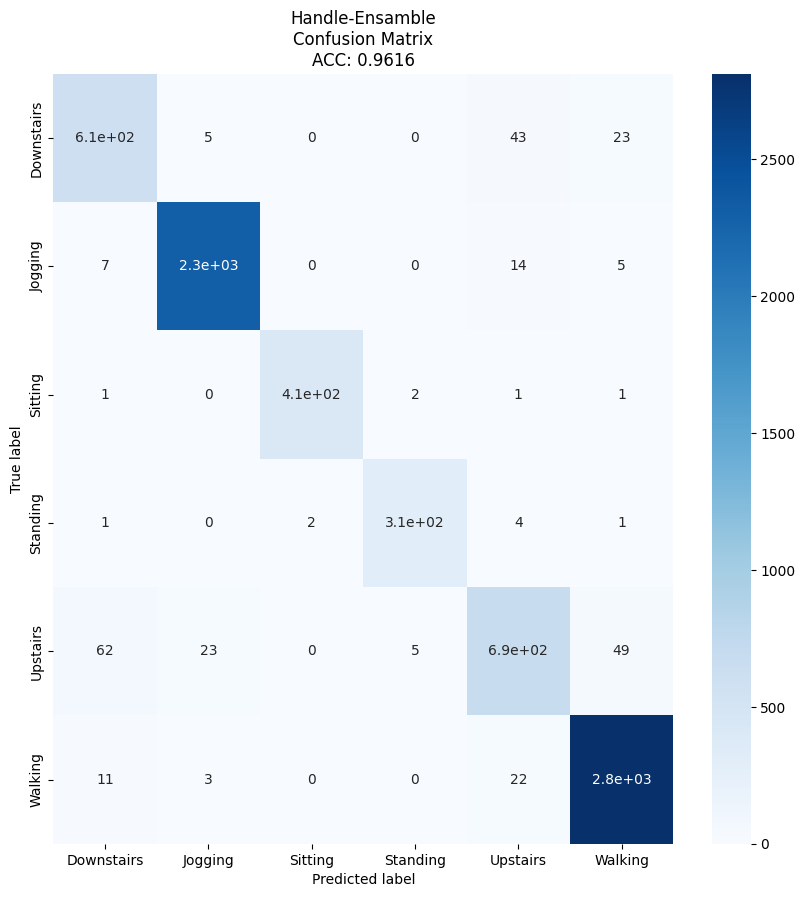

In [503]:
show_confusion_matrix(ensamble4_df, ensamble4_name)

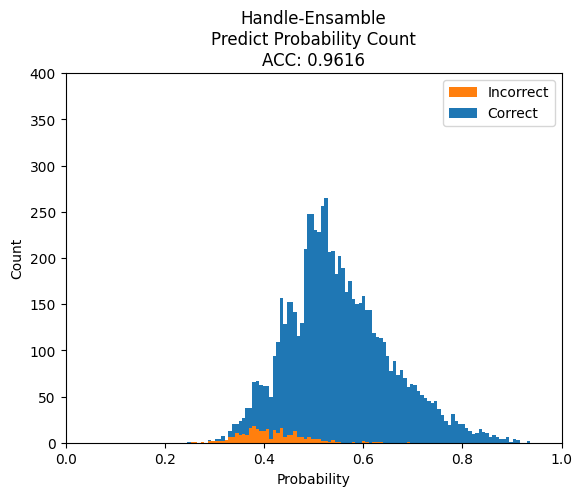

In [504]:
show_count(ensamble4_df, ensamble4_name)

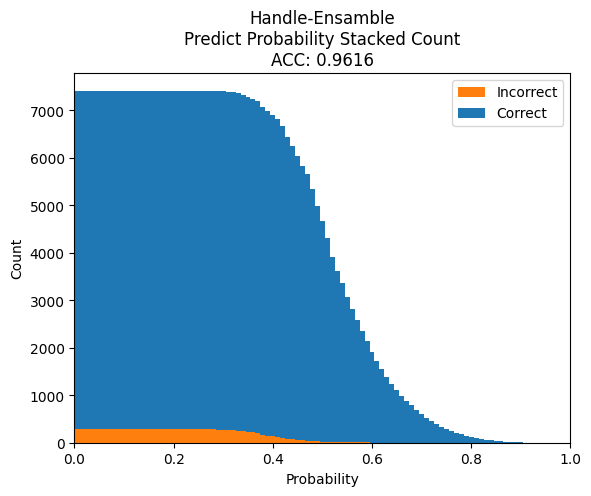

In [505]:
show_count_stacked(ensamble4_df, ensamble4_name)

In [506]:
print(f'Accuracy: {calc_accuracy(ensamble4_df):.4f}')
print(f'incorrect index num: {len(ensamble4_df.loc[ensamble4_df.true_label!=ensamble4_df.predict_label])}')
print("-"*50)
ensamble4_df.loc[ensamble4_df.predict_label!=ensamble4_df.true_label,"predict_label"].value_counts()

Accuracy: 0.9616
incorrect index num: 285
--------------------------------------------------


predict_label
Upstairs      84
Downstairs    82
Walking       79
Jogging       31
Standing       7
Sitting        2
Name: count, dtype: int64

In [507]:
calc_thredshold_df(ensamble4_df).dropna()

/tmp/ipykernel_9768/2184103812.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,accuracy,count
threshold,,
0.00,0.961554,7413
0.01,0.961554,7413
0.02,0.961554,7413
0.03,0.961554,7413
0.04,0.961554,7413
...,...,...
0.89,1.000000,14
0.90,1.000000,9
0.91,1.000000,5


In [508]:
score_dict ={
            "all": calc_score(ensamble4_df),
            "99.5%": calc_score(ensamble4_df.loc[ensamble4_df.method.str.contains("99.5%"),:]),
            "99%": calc_score(ensamble4_df.loc[ensamble4_df.method.str.contains("99%"),:]),
            "98%": calc_score(ensamble4_df.loc[ensamble4_df.method.str.contains("98%"),:]),
            "97%": calc_score(ensamble4_df.loc[ensamble4_df.method.str.contains("97%"),:]),
            "96%": calc_score(ensamble4_df.loc[ensamble4_df.method.str.contains("96%"),:]),
            "rest": calc_score(ensamble4_df.loc[ensamble4_df.method=="ConvBackBoneTransformer Layer7",:]),
}
score_df = pd.DataFrame(score_dict).T
handle_a_score = score_df.loc["99.5%",:].copy()
score_df

/home/nakagawaren/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nakagawaren/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nakagawaren/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,acc,rcl,prc,f1,size
all,0.961554,0.944322,0.950760,0.947349,7413.0
99.5%,0.996143,0.988288,0.990501,0.989388,5444.0
99%,0.937919,0.929635,0.932466,0.930738,1192.0
98%,0.799663,0.830962,0.812958,0.819918,594.0
97%,0.674074,0.446486,0.407336,0.423008,135.0
96%,0.473684,0.355519,0.345076,0.338009,38.0
rest,0.300000,0.340000,0.216667,0.223810,10.0


In [509]:
ensamble4_df.loc[ensamble4_df.method.str.contains("96%"),"true_label"].value_counts()

true_label
Upstairs      14
Walking       11
Downstairs     8
Sitting        2
Jogging        2
Standing       1
Name: count, dtype: int64

In [510]:
ensamble4_df.loc[ensamble4_df.method=="ConvBackBoneTransformer Layer7",:]

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label,method
1653,0.198789,0.000000,0.136175,0.235689,0.245029,0.184318,0.245029,Upstairs,Upstairs,ConvBackBoneTransformer Layer7
2531,0.287056,0.269687,0.000000,0.115040,0.151056,0.177161,0.287056,Downstairs,Standing,ConvBackBoneTransformer Layer7
2804,0.254518,0.000000,0.088282,0.205212,0.253295,0.198694,0.254518,Downstairs,Upstairs,ConvBackBoneTransformer Layer7
3969,0.194309,0.000000,0.134040,0.269578,0.126945,0.275128,0.275128,Walking,Upstairs,ConvBackBoneTransformer Layer7
4812,0.250544,0.058532,0.162930,0.000000,0.263474,0.264520,0.264520,Walking,Upstairs,ConvBackBoneTransformer Layer7
5541,0.291549,0.000000,0.141954,0.103264,0.225124,0.238109,0.291549,Downstairs,Downstairs,ConvBackBoneTransformer Layer7
6623,0.257876,0.062868,0.000000,0.080657,0.282655,0.315944,0.315944,Walking,Walking,ConvBackBoneTransformer Layer7
6743,0.284480,0.000000,0.053804,0.121639,0.246284,0.293793,0.293793,Walking,Upstairs,ConvBackBoneTransformer Layer7
7375,0.142776,0.000000,0.287320,0.294859,0.220831,0.054213,0.294859,Standing,Sitting,ConvBackBoneTransformer Layer7
7980,0.232481,0.177624,0.000000,0.006587,0.293160,0.290147,0.293160,Upstairs,Walking,ConvBackBoneTransformer Layer7


Text(0.5, 1.0, '99.5% Confidence-Line Venn Diagram\n    ACC: 0.9961\n    rest: 1969\n    ')

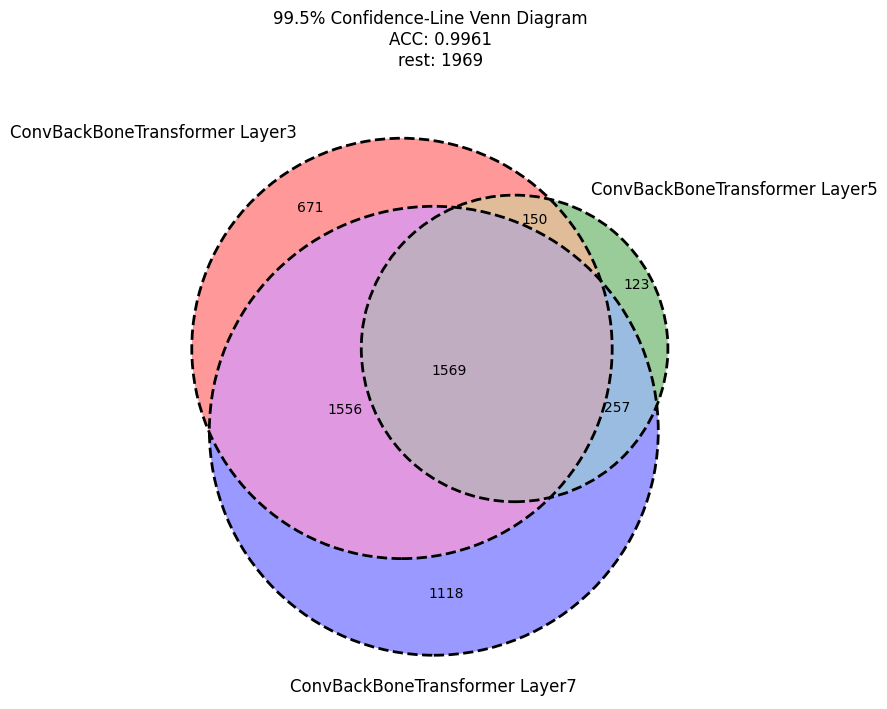

In [511]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

def draw_venn(sets:list, labels:list=None):
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    venn = venn3(sets, set_labels = labels)
    venn_circles = venn3_circles([set(s) for s in sets], linestyle='dashed')

# confidence-line
model1_set = set(convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_995threshold,:].index)
model2_set = set(convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_995threshold,:].index)
model3_set = set(convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_995threshold,:].index)

model_labels = ["ConvBackBoneTransformer Layer3", "ConvBackBoneTransformer Layer5", "ConvBackBoneTransformer Layer7"]
model_sets = [model1_set, model2_set, model3_set]

draw_venn(model_sets, model_labels)
plt.title(
    f'''99.5% Confidence-Line Venn Diagram
    ACC: {calc_accuracy(ensamble4_df.loc[ensamble4_df.method.str.contains("99.5%"),:]):.4f}
    rest: {len(ensamble4_df)-len(model1_set|model2_set|model3_set)}
    ''')


Text(0.5, 1.0, '99% Confidence-Line Venn Diagram\n    ACC: 0.9379\n    rest: 4383\n    ')

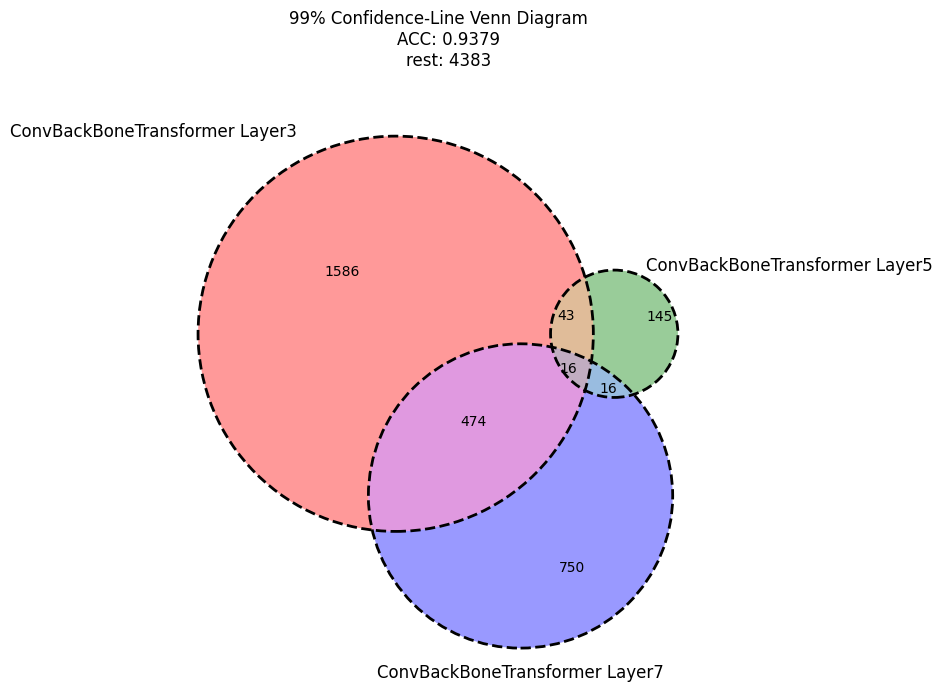

In [512]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

def draw_venn(sets:list, labels:list=None):
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    venn = venn3(sets, set_labels = labels)
    venn_circles = venn3_circles([set(s) for s in sets], linestyle='dashed')

# confidence-line
model1_set = set(convbbt_layer3_test_df.loc[(convbbt_layer3_995threshold>convbbt_layer3_test_df.predict_probability)&(convbbt_layer3_test_df.predict_probability>convbbt_layer3_99threshold),:].index)
model2_set = set(convbbt_layer5_test_df.loc[(convbbt_layer5_995threshold>convbbt_layer5_test_df.predict_probability)&(convbbt_layer5_test_df.predict_probability>convbbt_layer5_99threshold),:].index)
model3_set = set(convbbt_layer7_test_df.loc[(convbbt_layer7_995threshold>convbbt_layer7_test_df.predict_probability)&(convbbt_layer7_test_df.predict_probability>convbbt_layer7_99threshold),:].index)

model_labels = ["ConvBackBoneTransformer Layer3", "ConvBackBoneTransformer Layer5", "ConvBackBoneTransformer Layer7"]
model_sets = [model1_set, model2_set, model3_set]

draw_venn(model_sets, model_labels)
plt.title(
    f'''99% Confidence-Line Venn Diagram
    ACC: {calc_accuracy(ensamble4_df.loc[ensamble4_df.method.str.contains("99%"),:]):.4f}
    rest: {len(ensamble4_df)-len(model1_set|model2_set|model3_set)}
    ''')


Text(0.5, 1.0, '98% Confidence-Line Venn Diagram\n    ACC: 0.7997\n    rest: 3201\n    ')

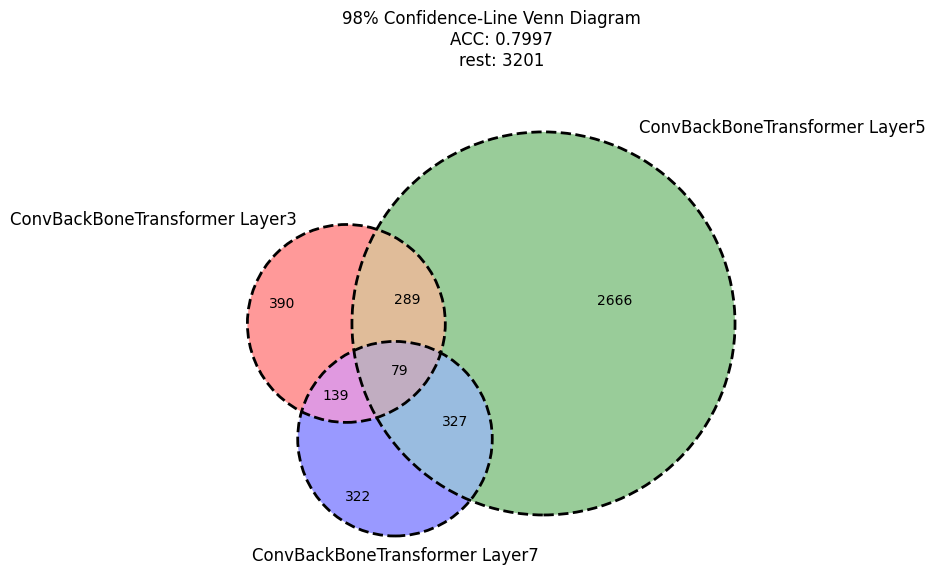

In [513]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

def draw_venn(sets:list, labels:list=None):
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    venn = venn3(sets, set_labels = labels)
    venn_circles = venn3_circles([set(s) for s in sets], linestyle='dashed')

# confidence-line
model1_set = set(convbbt_layer3_test_df.loc[(convbbt_layer3_99threshold>convbbt_layer3_test_df.predict_probability)&(convbbt_layer3_test_df.predict_probability>convbbt_layer3_98threshold),:].index)
model2_set = set(convbbt_layer5_test_df.loc[(convbbt_layer5_99threshold>convbbt_layer5_test_df.predict_probability)&(convbbt_layer5_test_df.predict_probability>convbbt_layer5_98threshold),:].index)
model3_set = set(convbbt_layer7_test_df.loc[(convbbt_layer7_99threshold>convbbt_layer7_test_df.predict_probability)&(convbbt_layer7_test_df.predict_probability>convbbt_layer7_98threshold),:].index)

model_labels = ["ConvBackBoneTransformer Layer3", "ConvBackBoneTransformer Layer5", "ConvBackBoneTransformer Layer7"]
model_sets = [model1_set, model2_set, model3_set]

draw_venn(model_sets, model_labels)
plt.title(
    f'''98% Confidence-Line Venn Diagram
    ACC: {calc_accuracy(ensamble4_df.loc[ensamble4_df.method.str.contains("98%"),:]):.4f}
    rest: {len(ensamble4_df)-len(model1_set|model2_set|model3_set)}
    ''')


Text(0.5, 1.0, '97% Confidence-Line Venn Diagram\n    ACC: 0.6741\n    rest: 5979\n    ')

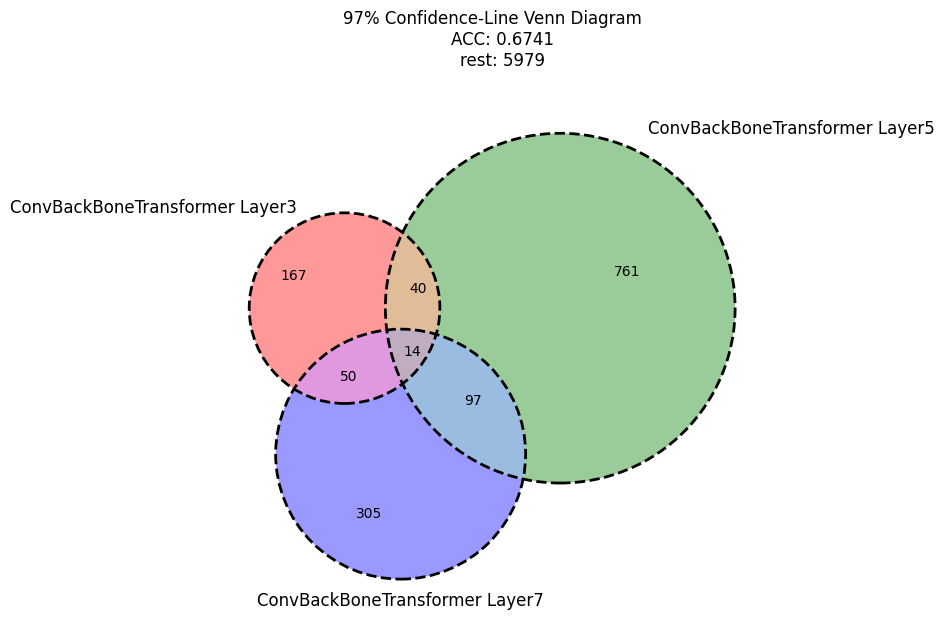

In [514]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

def draw_venn(sets:list, labels:list=None):
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    venn = venn3(sets, set_labels = labels)
    venn_circles = venn3_circles([set(s) for s in sets], linestyle='dashed')

# confidence-line
model1_set = set(convbbt_layer3_test_df.loc[(convbbt_layer3_98threshold>convbbt_layer3_test_df.predict_probability)&(convbbt_layer3_test_df.predict_probability>convbbt_layer3_97threshold),:].index)
model2_set = set(convbbt_layer5_test_df.loc[(convbbt_layer5_98threshold>convbbt_layer5_test_df.predict_probability)&(convbbt_layer5_test_df.predict_probability>convbbt_layer5_97threshold),:].index)
model3_set = set(convbbt_layer7_test_df.loc[(convbbt_layer7_98threshold>convbbt_layer7_test_df.predict_probability)&(convbbt_layer7_test_df.predict_probability>convbbt_layer7_97threshold),:].index)

model_labels = ["ConvBackBoneTransformer Layer3", "ConvBackBoneTransformer Layer5", "ConvBackBoneTransformer Layer7"]
model_sets = [model1_set, model2_set, model3_set]

draw_venn(model_sets, model_labels)
plt.title(
    f'''97% Confidence-Line Venn Diagram
    ACC: {calc_accuracy(ensamble4_df.loc[ensamble4_df.method.str.contains("97%"),:]):.4f}
    rest: {len(ensamble4_df)-len(model1_set|model2_set|model3_set)}
    ''')


Text(0.5, 1.0, '96% Confidence-Line Venn Diagram\n    ACC: 0.4737\n    rest: 6768\n    ')

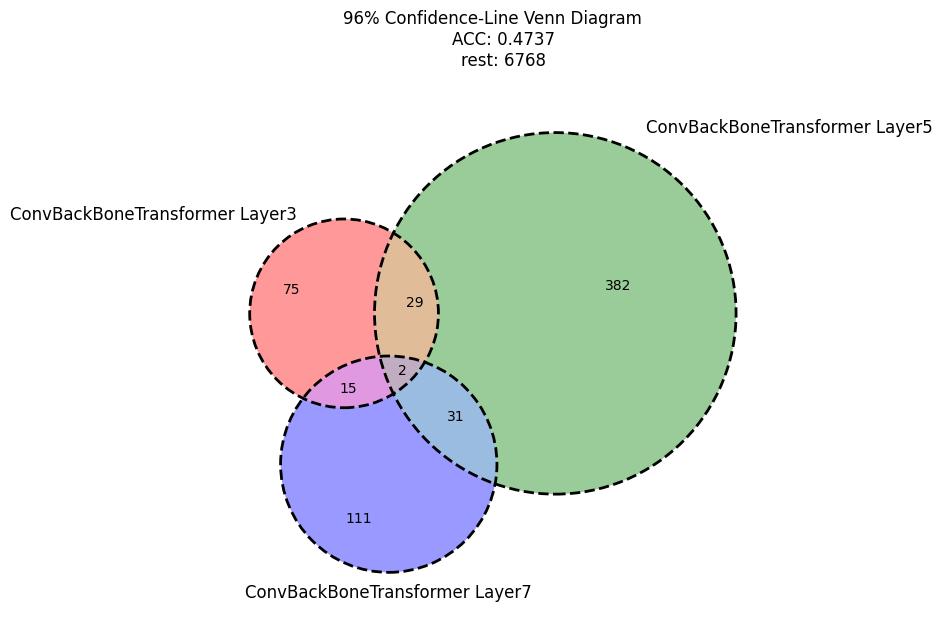

In [515]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

def draw_venn(sets:list, labels:list=None):
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    venn = venn3(sets, set_labels = labels)
    venn_circles = venn3_circles([set(s) for s in sets], linestyle='dashed')

# confidence-line
model1_set = set(convbbt_layer3_test_df.loc[(convbbt_layer3_97threshold>convbbt_layer3_test_df.predict_probability)&(convbbt_layer3_test_df.predict_probability>convbbt_layer3_96threshold),:].index)
model2_set = set(convbbt_layer5_test_df.loc[(convbbt_layer5_97threshold>convbbt_layer5_test_df.predict_probability)&(convbbt_layer5_test_df.predict_probability>convbbt_layer5_96threshold),:].index)
model3_set = set(convbbt_layer7_test_df.loc[(convbbt_layer7_97threshold>convbbt_layer7_test_df.predict_probability)&(convbbt_layer7_test_df.predict_probability>convbbt_layer7_96threshold),:].index)

model_labels = ["ConvBackBoneTransformer Layer3", "ConvBackBoneTransformer Layer5", "ConvBackBoneTransformer Layer7"]
model_sets = [model1_set, model2_set, model3_set]

draw_venn(model_sets, model_labels)
plt.title(
    f'''96% Confidence-Line Venn Diagram
    ACC: {calc_accuracy(ensamble4_df.loc[ensamble4_df.method.str.contains("96%"),:]):.4f}
    rest: {len(ensamble4_df)-len(model1_set|model2_set|model3_set)}
    ''')


Text(0.5, 1.0, 'Incorrect Venn Diagram\n    ')

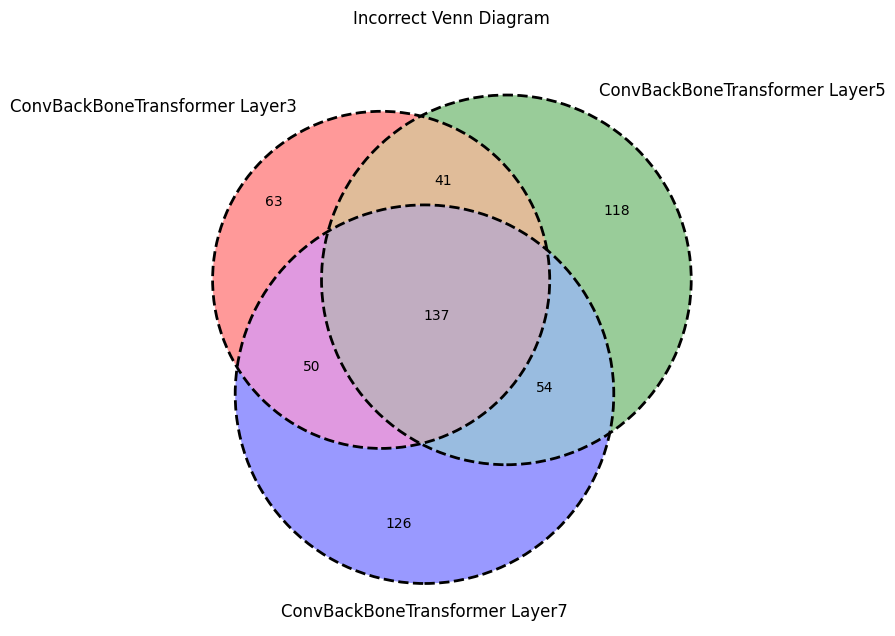

In [516]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

def draw_venn(sets:list, labels:list=None):
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    venn = venn3(sets, set_labels = labels)
    venn_circles = venn3_circles([set(s) for s in sets], linestyle='dashed')

# confidence-line
model1_set = set(convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_label!=convbbt_layer3_test_df.true_label,:].index)
model2_set = set(convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_label!=convbbt_layer5_test_df.true_label,:].index)
model3_set = set(convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_label!=convbbt_layer7_test_df.true_label,:].index)

model_labels = ["ConvBackBoneTransformer Layer3", "ConvBackBoneTransformer Layer5", "ConvBackBoneTransformer Layer7"]
model_sets = [model1_set, model2_set, model3_set]

draw_venn(model_sets, model_labels)
plt.title(
    f'''Incorrect Venn Diagram
    ''')


Text(0.5, 1.0, 'ACC: 0.9616')

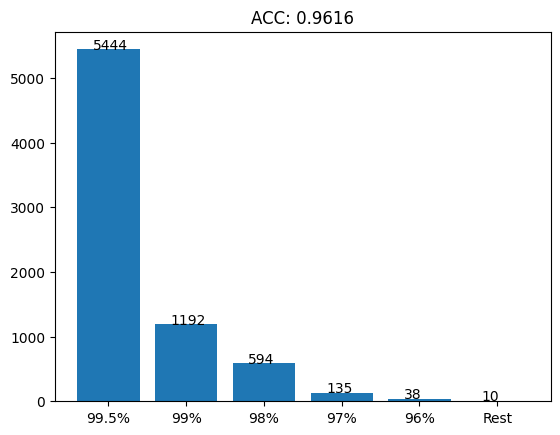

In [517]:
class_A_set = set(ensamble4_df.loc[ensamble4_df.method.str.contains("99.5%"),:].index)
class_B_set = set(ensamble4_df.loc[ensamble4_df.method.str.contains("99%"),:].index)
class_C_set = set(ensamble4_df.loc[ensamble4_df.method.str.contains("98%"),:].index)
class_D_set = set(ensamble4_df.loc[ensamble4_df.method.str.contains("97%"),:].index)
class_F_set = set(ensamble4_df.loc[ensamble4_df.method.str.contains("96%"),:].index)
class_G_set = set(ensamble4_df.loc[ensamble4_df.method=="ConvBackBoneTransformer Layer7",:].index)

class_name  = ["99.5%", "99%", "98%", "97%", "96%", "Rest"]
class_sets = [class_A_set, class_B_set, class_C_set, class_D_set, class_F_set, class_G_set]

plt.bar(class_name, [len(s) for s in class_sets])
plt.text(-0.2, len(class_A_set)+0.01, f'{len(class_A_set)}')
plt.text(0.8, len(class_B_set)+0.01, f'{len(class_B_set)}')
plt.text(1.8, len(class_C_set)+0.01, f'{len(class_C_set)}')
plt.text(2.8, len(class_D_set)+0.01, f'{len(class_D_set)}')
plt.text(3.8, len(class_F_set)+0.01, f'{len(class_F_set)}')
plt.text(4.8, len(class_G_set)+0.01, f'{len(class_G_set)}')
plt.title(f'''ACC: {calc_accuracy(ensamble4_df):.4f}''')

## Compare

In [518]:
len(ensamble2_df)

7413

In [519]:
vote_a_score["size"] /= len(ensamble2_df)
vote_a_score

acc     0.985700
rcl     0.974219
prc     0.979816
f1      0.976981
size    0.933900
Name: Vote 3, dtype: float64

In [520]:
handle_a_score["size"] /= len(ensamble4_df)
handle_a_score

acc     0.996143
rcl     0.988288
prc     0.990501
f1      0.989388
size    0.734386
Name: 99.5%, dtype: float64

In [521]:
compare_num = len(vote_a_score)+1
labels = vote_a_score.index
vote_a_score = vote_a_score.values
vote_a_score = np.concatenate((vote_a_score, [vote_a_score[0]]))
handle_a_score = handle_a_score.values
handle_a_score = np.concatenate((handle_a_score, [handle_a_score[0]]))

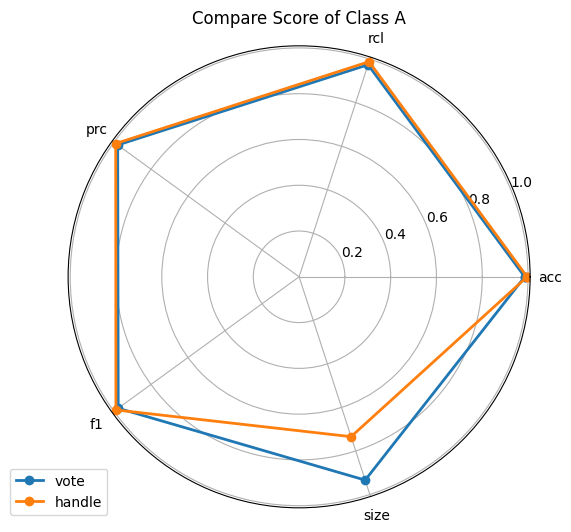

In [522]:
# make radar chart
angles = np.linspace(0, 2*np.pi, compare_num)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, polar=True)

ax.plot(angles, vote_a_score, 'o-', linewidth=2, label="vote")
# ax.fill(angles, vote_a_score, alpha=0.25)
ax.plot(angles, handle_a_score, 'o-', linewidth=2, label="handle")
# ax.fill(angles, handle_a_score, alpha=0.25)
ax.set_thetagrids(angles[:-1] * 180/np.pi, labels)
ax.set_title("Compare Score of Class A")
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

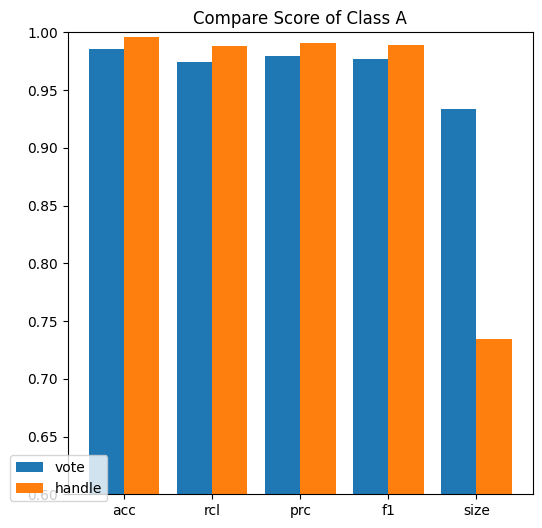

In [529]:
# make bar chart with side by side
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
# show upper 0.5

width = 0.4
x = np.arange(compare_num-1)
ax.bar(x, vote_a_score[:-1], width=width, label="vote")
ax.bar(x + width, handle_a_score[:-1], width=width, label="handle")
ax.set_xticks(x + width/2)
ax.set_xticklabels(labels)
ax.set_ylim(0.6, 1)

ax.set_title("Compare Score of Class A")
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()